## 1.Importing Libraries

In [1]:
import os
import sys
import random
import warnings
import zipfile

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf

Using TensorFlow backend.


**Specify Path**

In [2]:
# Unzipping some files
stage1_train = 'stage1_train'
stage1_test = 'stage1_test'

In [3]:
# Will unzip the files so that you can see them..
with zipfile.ZipFile("../input/data-science-bowl-2018/"+stage1_train+".zip","r") as z:
    z.extractall(stage1_train)

# Will unzip the files so that you can see them..
with zipfile.ZipFile("../input/data-science-bowl-2018/"+stage1_test+".zip","r") as z:
    z.extractall(stage1_test)

**Specify some constants**

In [4]:
TRAIN_PATH = '../working/stage1_train/'
TEST_PATH = '../working/stage1_test/'
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

**Obtain id's of images**

In [5]:
# Obtain train and test IDs
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

In [6]:
import os
import random
import sys
import warnings
import numpy as np
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from keras.utils import Progbar

## 2.Defining functions and Loading required data

In [7]:
def get_train_data(IMG_WIDTH=256, IMG_HEIGHT=256, IMG_CHANNELS=3):
    X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
    Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    print('Getting and resizing train images and masks ... ')
    sys.stdout.flush()
    if os.path.isfile('train_img.npy') and os.path.isfile('train_mask.npy'):
        print('Train file loaded from memory')
        X_train = np.load('train_img.npy')
        Y_train = np.load('train_mask.npy')
        return X_train, Y_train
    a = Progbar(len(train_ids))
    for n, id_ in enumerate(train_ids):
        path = TRAIN_PATH + id_
        img = imread(path + '/images/' + id_ + '.png')[:, :, :IMG_CHANNELS]
        img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
        X_train[n] = img
        mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
        for mask_file in next(os.walk(path + '/masks/'))[2]:
            mask_ = imread(path + '/masks/' + mask_file)
            mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant',
                                        preserve_range=True), axis=-1)
            mask = np.maximum(mask, mask_)
        Y_train[n] = mask
        a.update(n)
    np.save('train_img', X_train)
    np.save('train_mask', Y_train)
    return X_train, Y_train

In [8]:
def get_test_data(IMG_WIDTH=256, IMG_HEIGHT=256, IMG_CHANNELS=3):
    X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
    sizes_test = []
    print('\nGetting and resizing test images ... ')
    sys.stdout.flush()
    if os.path.isfile('test_img.npy') and os.path.isfile('test_size.npy'):
        print('Test file loaded from memory')
        X_test = np.load('test_img.npy')
        sizes_test = np.load('test_size.npy')
        return X_test,sizes_test
    b = Progbar(len(test_ids))
    for n, id_ in enumerate(test_ids):
        path = TEST_PATH + id_
        img = imread(path + '/images/' + id_ + '.png')[:, :, :IMG_CHANNELS]
        sizes_test.append([img.shape[0], img.shape[1]])
        img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
        X_test[n] = img
        b.update(n)
    np.save('test_img', X_test)
    np.save('test_size', sizes_test)
    return X_test,sizes_test

In [9]:
# get train_data
train_img, train_mask = get_train_data()

# get test_data
test_img, test_img_sizes = get_test_data()

Getting and resizing train images and masks ... 
669/670 [============================>.] - ETA: 0s
Getting and resizing test images ... 
64/65 [============================>.] - ETA: 0s

## 3.Defining U-Net model and metrics

**As a metric I will use Dice Coefficient**

In [10]:
from keras.models import Model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose,Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras import backend as K

smooth = 1.


# Metric function
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def make_model(IMG_WIDTH=256,IMG_HEIGHT=256,IMG_CHANNELS=3):
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = Lambda(lambda x: x / 255)(inputs)
    c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c5)

    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[dice_coef])
    return model

In [11]:
# get u_net model
u_net = make_model()

### Preliminary training on 50 Epochs

In [12]:
print("\nTraining...")
u_net.fit(train_img, train_mask, batch_size=16, epochs=50)


Training...
Epoch 1/50
670/670 [==============================] - 11s 16ms/step - loss: 0.2596 - dice_coef: 0.5345
Epoch 2/50
670/670 [==============================] - 4s 6ms/step - loss: 0.1181 - dice_coef: 0.7908
Epoch 3/50
670/670 [==============================] - 4s 6ms/step - loss: 0.1008 - dice_coef: 0.8229
Epoch 4/50
670/670 [==============================] - 4s 6ms/step - loss: 0.0953 - dice_coef: 0.8292
Epoch 5/50
670/670 [==============================] - 4s 6ms/step - loss: 0.1285 - dice_coef: 0.7864
Epoch 6/50
670/670 [==============================] - 4s 6ms/step - loss: 0.1036 - dice_coef: 0.8194
Epoch 7/50
670/670 [==============================] - 4s 6ms/step - loss: 0.0912 - dice_coef: 0.8349
Epoch 8/50
670/670 [==============================] - 4s 6ms/step - loss: 0.0892 - dice_coef: 0.8414
Epoch 9/50
670/670 [==============================] - 4s 6ms/step - loss: 0.0877 - dice_coef: 0.8465
Epoch 10/50
670/670 [==============================] - 4s 6ms/step - loss: 0

### Predicting masks for test images

In [13]:
print("Predicting")
# Predict on test data
test_mask = u_net.predict(test_img, verbose=1)

Predicting
65/65 [==============================] - 1s 13ms/step


### Obtained test_mask

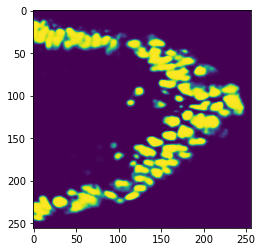

In [14]:
plt.imshow(test_mask[0].reshape(256,256))

In [15]:
test_img.shape

(65, 256, 256, 3)

### Actual Image

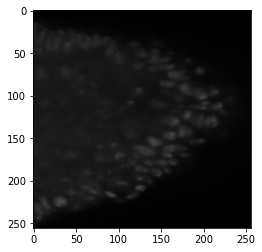

In [16]:
plt.imshow(test_img[0])

In [17]:
X_train, X_valid, y_train, y_valid = train_test_split(train_img, train_mask, test_size=0.15, random_state=2018)

## 4.Defining another model

In [18]:
# get u_net model
u_net_1 = make_model()

In [19]:
print("\nTraining...")
u_net_1.fit(X_train, y_train, batch_size=16, epochs=50)


Training...
Epoch 1/50
569/569 [==============================] - 5s 10ms/step - loss: 0.3852 - dice_coef: 0.2819
Epoch 2/50
569/569 [==============================] - 4s 6ms/step - loss: 0.1807 - dice_coef: 0.6701
Epoch 3/50
569/569 [==============================] - 4s 6ms/step - loss: 0.1334 - dice_coef: 0.7494
Epoch 4/50
569/569 [==============================] - 4s 6ms/step - loss: 0.1117 - dice_coef: 0.7952
Epoch 5/50
569/569 [==============================] - 4s 6ms/step - loss: 0.1013 - dice_coef: 0.8164
Epoch 6/50
569/569 [==============================] - 4s 6ms/step - loss: 0.0995 - dice_coef: 0.8180
Epoch 7/50
569/569 [==============================] - 4s 6ms/step - loss: 0.0886 - dice_coef: 0.8378
Epoch 8/50
569/569 [==============================] - 3s 6ms/step - loss: 0.0983 - dice_coef: 0.8187
Epoch 9/50
569/569 [==============================] - 4s 6ms/step - loss: 0.0862 - dice_coef: 0.8435
Epoch 10/50
569/569 [==============================] - 4s 6ms/step - loss: 0.

In [20]:
print("Predicting")
# Predict on test data
test_mask_validation = u_net_1.predict(X_valid, verbose=1)

Predicting
101/101 [==============================] - 1s 6ms/step


### 4.1 Predicted mask

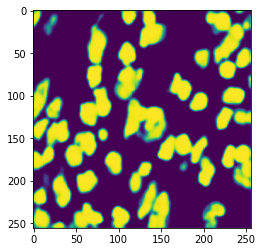

In [21]:
plt.imshow(test_mask_validation[0].reshape(256,256))

### 4.2 Ground-truth Mask

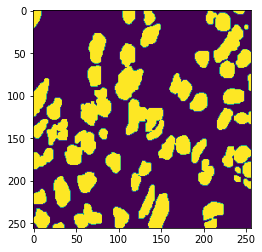

In [22]:
plt.imshow(y_valid[0].reshape(256,256))

**Now let's evaluate our model**

In [23]:
u_net_1.evaluate(X_valid,y_valid, verbose=1)

101/101 [==============================] - 0s 4ms/step


[0.07358102177703145, 0.897159218788147]

In [24]:
dice_score = 0
for i in range(len(test_mask_validation)):
    dice_score += dice_coef(test_mask_validation[i].reshape(256,256),y_valid[i].reshape(256,256).astype("float32")).numpy()
print(dice_score/len(test_mask_validation))

0.8706865903764668


### Let's add few early stopping

**Monitoring dice_coefficient**

In [25]:
callbacks = [
    EarlyStopping(monitor='dice_coef', patience=10, verbose=1),
    ReduceLROnPlateau(monitor='dice_coef', factor=0.1, patience=3, min_lr=0.000001, verbose=1),
    ModelCheckpoint('model_weights_1.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [26]:
# get u_net model
u_net_es = make_model()

In [27]:
results = u_net_es.fit(X_train, y_train, batch_size=16, epochs=100, callbacks=callbacks)

Epoch 1/100
569/569 [==============================] - 5s 9ms/step - loss: 0.3442 - dice_coef: 0.3736
Epoch 2/100
 32/569 [>.............................] - ETA: 3s - loss: 0.1793 - dice_coef: 0.6583

/opt/conda/lib/python3.7/site-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_loss available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


569/569 [==============================] - 3s 6ms/step - loss: 0.1465 - dice_coef: 0.7322
Epoch 3/100
569/569 [==============================] - 3s 6ms/step - loss: 0.1178 - dice_coef: 0.7845
Epoch 4/100
569/569 [==============================] - 3s 6ms/step - loss: 0.1013 - dice_coef: 0.8092

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 5/100
569/569 [==============================] - 3s 6ms/step - loss: 0.0942 - dice_coef: 0.8333
Epoch 6/100
569/569 [==============================] - 3s 6ms/step - loss: 0.0930 - dice_coef: 0.8270
Epoch 7/100
569/569 [==============================] - 3s 6ms/step - loss: 0.0922 - dice_coef: 0.8327

Epoch 00007: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Epoch 8/100
569/569 [==============================] - 3s 6ms/step - loss: 0.0905 - dice_coef: 0.8361
Epoch 9/100
569/569 [==============================] - 4s 6ms/step - loss: 0.0896 - dice_coef: 0.8346
Epoch 10/100
569/569 [==========

### Monitoring Losses

In [28]:
callbacks1 = [
    EarlyStopping(monitor='loss', patience=10, verbose=1),
    ReduceLROnPlateau(monitor='loss', factor=0.1, patience=3, min_lr=0.000001, verbose=1),
    ModelCheckpoint('model_weights_1.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [29]:
# get u_net model
u_net_es_loss = make_model()

In [30]:
results = u_net_es_loss.fit(X_train, y_train, batch_size=16, epochs=200, callbacks=callbacks1)

Epoch 1/200
569/569 [==============================] - 5s 9ms/step - loss: 0.4479 - dice_coef: 0.2787
Epoch 2/200
569/569 [==============================] - 3s 6ms/step - loss: 0.1950 - dice_coef: 0.6379
Epoch 3/200
569/569 [==============================] - 4s 6ms/step - loss: 0.1373 - dice_coef: 0.7438
Epoch 4/200
569/569 [==============================] - 4s 6ms/step - loss: 0.1121 - dice_coef: 0.7976
Epoch 5/200
569/569 [==============================] - 4s 6ms/step - loss: 0.1033 - dice_coef: 0.8131
Epoch 6/200
569/569 [==============================] - 4s 6ms/step - loss: 0.0981 - dice_coef: 0.8213
Epoch 7/200
569/569 [==============================] - 4s 6ms/step - loss: 0.0935 - dice_coef: 0.8302
Epoch 8/200
569/569 [==============================] - 4s 6ms/step - loss: 0.0904 - dice_coef: 0.8386
Epoch 9/200
569/569 [==============================] - 4s 6ms/step - loss: 0.0904 - dice_coef: 0.8374
Epoch 10/200
569/569 [==============================] - 4s 6ms/step - loss: 0.0821

### Plot Learning Curve

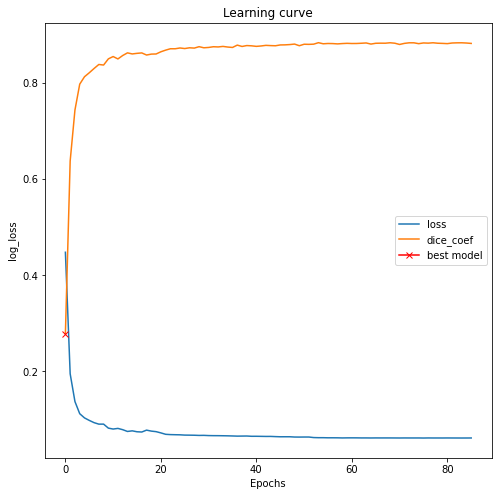

In [31]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["dice_coef"], label="dice_coef")
plt.plot( np.argmin(results.history["dice_coef"]), np.min(results.history["dice_coef"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

In [32]:
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose,Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K


def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def conv2d_block(input_tensor, n_filters, kernel_size=3, dropout=1, activation='relu'):
    # first layer
    c1 = Conv2D(filters=n_filters, activation=activation, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(input_tensor)
    c1 = Dropout(0.1)(c1)
    # second layer
    c1 = Conv2D(filters=n_filters, activation=activation, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(c1)
    return c1


def unet_model(IMG_WIDTH=256,IMG_HEIGHT=256,IMG_CHANNELS=3, activation='relu', dropout=0.1):
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = Lambda(lambda x: x / 255)(inputs)
    n_filters = 16
    
    c1 = conv2d_block(s, 16, kernel_size=3, dropout=dropout*1, activation=activation)
    p1 = MaxPooling2D((2, 2), name='pool1')(c1)
    
    
    c2 = conv2d_block(p1, 32, kernel_size=3, dropout=dropout*1, activation=activation)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = conv2d_block(p2, 64, kernel_size=3, dropout=dropout*2, activation=activation)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = conv2d_block(p3, 128, kernel_size=3, dropout=dropout*2, activation=activation)
    p4 = MaxPooling2D((2, 2))(c4)

    c5 = conv2d_block(p4, 256, kernel_size=3, dropout=dropout*3, activation=activation)

    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = conv2d_block(u6, 128, kernel_size=3, dropout=dropout*2, activation=activation)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = conv2d_block(u7, 64, kernel_size=3, dropout=dropout*2, activation=activation)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = conv2d_block(u8, 32, kernel_size=3, dropout=dropout*1, activation=activation)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = conv2d_block(u9, 16, kernel_size=3, dropout=dropout*1, activation=activation)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[dice_coef])
    return model

In [33]:
X_train, X_valid, y_train, y_valid = train_test_split(train_img, train_mask, test_size=0.15, random_state=2018)

### Testing our model with different activation functions

In [34]:
# get u_net model
unet_relu = unet_model(activation="relu")

In [35]:
print("\nTraining...")
unet_relu.fit(X_train, y_train, batch_size=16, epochs=50)


Training...
Epoch 1/50
569/569 [==============================] - 5s 8ms/step - loss: 0.6263 - dice_coef: 0.2064
Epoch 2/50
569/569 [==============================] - 3s 6ms/step - loss: 0.3163 - dice_coef: 0.3323
Epoch 3/50
569/569 [==============================] - 3s 6ms/step - loss: 0.1993 - dice_coef: 0.5621
Epoch 4/50
569/569 [==============================] - 3s 6ms/step - loss: 0.1248 - dice_coef: 0.7642
Epoch 5/50
569/569 [==============================] - 3s 6ms/step - loss: 0.1070 - dice_coef: 0.7978
Epoch 6/50
569/569 [==============================] - 3s 6ms/step - loss: 0.1027 - dice_coef: 0.8081
Epoch 7/50
569/569 [==============================] - 3s 6ms/step - loss: 0.0936 - dice_coef: 0.8261
Epoch 8/50
569/569 [==============================] - 3s 6ms/step - loss: 0.0888 - dice_coef: 0.8328
Epoch 9/50
569/569 [==============================] - 3s 6ms/step - loss: 0.0867 - dice_coef: 0.8414
Epoch 10/50
569/569 [==============================] - 3s 6ms/step - loss: 0.0

In [36]:
unet_relu.evaluate(X_valid,y_valid, verbose=1)

101/101 [==============================] - 0s 5ms/step


[0.08387004606204458, 0.9004536271095276]

### 5.Elu activation

In [37]:
# get u_net model
unet_elu = unet_model(activation="elu")

In [38]:
print("\nTraining...")
unet_elu.fit(X_train, y_train, batch_size=16, epochs=50)


Training...
Epoch 1/50
569/569 [==============================] - 5s 9ms/step - loss: 0.2994 - dice_coef: 0.4630
Epoch 2/50
569/569 [==============================] - 3s 6ms/step - loss: 0.1276 - dice_coef: 0.7561
Epoch 3/50
569/569 [==============================] - 3s 6ms/step - loss: 0.1059 - dice_coef: 0.8082
Epoch 4/50
569/569 [==============================] - 3s 6ms/step - loss: 0.0978 - dice_coef: 0.8203
Epoch 5/50
569/569 [==============================] - 3s 6ms/step - loss: 0.0991 - dice_coef: 0.8245
Epoch 6/50
569/569 [==============================] - 3s 6ms/step - loss: 0.1076 - dice_coef: 0.8064
Epoch 7/50
569/569 [==============================] - 3s 6ms/step - loss: 0.0956 - dice_coef: 0.8284
Epoch 8/50
569/569 [==============================] - 3s 6ms/step - loss: 0.0890 - dice_coef: 0.8407
Epoch 9/50
569/569 [==============================] - 4s 6ms/step - loss: 0.0872 - dice_coef: 0.8426
Epoch 10/50
569/569 [==============================] - 3s 6ms/step - loss: 0.0

In [39]:
unet_elu.evaluate(X_valid,y_valid, verbose=1)

101/101 [==============================] - 0s 4ms/step


[0.08734762963682118, 0.9077357053756714]

**Trying adding validation during learning**

In [40]:
# get u_net model
unet_elu_valid = unet_model(activation="elu")

In [41]:
unet_elu_valid.fit(X_train, y_train, batch_size=16, epochs=50, validation_data=(X_valid, y_valid))

Train on 569 samples, validate on 101 samples
Epoch 1/50
569/569 [==============================] - 5s 9ms/step - loss: 0.3424 - dice_coef: 0.4025 - val_loss: 0.2259 - val_dice_coef: 0.6753
Epoch 2/50
569/569 [==============================] - 4s 6ms/step - loss: 0.1466 - dice_coef: 0.7261 - val_loss: 0.1563 - val_dice_coef: 0.8066
Epoch 3/50
569/569 [==============================] - 4s 6ms/step - loss: 0.1233 - dice_coef: 0.7772 - val_loss: 0.1266 - val_dice_coef: 0.8275
Epoch 4/50
569/569 [==============================] - 4s 7ms/step - loss: 0.1055 - dice_coef: 0.8098 - val_loss: 0.1148 - val_dice_coef: 0.8488
Epoch 5/50
569/569 [==============================] - 4s 6ms/step - loss: 0.1019 - dice_coef: 0.8158 - val_loss: 0.1172 - val_dice_coef: 0.8388
Epoch 6/50
569/569 [==============================] - 4s 6ms/step - loss: 0.0969 - dice_coef: 0.8236 - val_loss: 0.1074 - val_dice_coef: 0.8527
Epoch 7/50
569/569 [==============================] - 4s 7ms/step - loss: 0.0914 - dice_co

### Adding callbacks

In [42]:
callbacks_new = [
    EarlyStopping(monitor='dice_coef', mode='max', patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model_weights.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [43]:
# get u_net model
unet_elu_call = unet_model(activation="elu")

In [44]:
unet_elu_call.fit(X_train, y_train, batch_size=16, epochs=50, 
                  validation_data=(X_valid, y_valid), callbacks=callbacks_new)

Train on 569 samples, validate on 101 samples
Epoch 1/50
569/569 [==============================] - 6s 10ms/step - loss: 0.3315 - dice_coef: 0.4200 - val_loss: 0.1603 - val_dice_coef: 0.7437

Epoch 00001: val_loss improved from inf to 0.16034, saving model to model_weights.h5
Epoch 2/50
569/569 [==============================] - 4s 6ms/step - loss: 0.1388 - dice_coef: 0.7454 - val_loss: 0.1373 - val_dice_coef: 0.8084

Epoch 00002: val_loss improved from 0.16034 to 0.13726, saving model to model_weights.h5
Epoch 3/50
569/569 [==============================] - 4s 6ms/step - loss: 0.1137 - dice_coef: 0.7939 - val_loss: 0.1086 - val_dice_coef: 0.8442

Epoch 00003: val_loss improved from 0.13726 to 0.10862, saving model to model_weights.h5
Epoch 4/50
569/569 [==============================] - 4s 6ms/step - loss: 0.0995 - dice_coef: 0.8181 - val_loss: 0.1078 - val_dice_coef: 0.8609

Epoch 00004: val_loss improved from 0.10862 to 0.10775, saving model to model_weights.h5
Epoch 5/50
569/569 [=

#### Sigmoid activation

In [45]:
# get u_net model
unet_sigmoid = unet_model(activation="sigmoid")

In [46]:
print("\nTraining...")
unet_sigmoid.fit(X_train, y_train, batch_size=16, epochs=50)


Training...
Epoch 1/50
569/569 [==============================] - 5s 9ms/step - loss: 0.4450 - dice_coef: 0.1549
Epoch 2/50
569/569 [==============================] - 4s 6ms/step - loss: 0.4324 - dice_coef: 0.1565
Epoch 3/50
569/569 [==============================] - 4s 6ms/step - loss: 0.4307 - dice_coef: 0.1551
Epoch 4/50
569/569 [==============================] - 3s 6ms/step - loss: 0.4192 - dice_coef: 0.1676
Epoch 5/50
569/569 [==============================] - 4s 6ms/step - loss: 0.3758 - dice_coef: 0.2330
Epoch 6/50
569/569 [==============================] - 4s 6ms/step - loss: 0.3428 - dice_coef: 0.2918
Epoch 7/50
569/569 [==============================] - 4s 6ms/step - loss: 0.3303 - dice_coef: 0.3127
Epoch 8/50
569/569 [==============================] - 4s 6ms/step - loss: 0.3231 - dice_coef: 0.3285
Epoch 9/50
569/569 [==============================] - 4s 6ms/step - loss: 0.3188 - dice_coef: 0.3313
Epoch 10/50
569/569 [==============================] - 4s 6ms/step - loss: 0.3

In [47]:
unet_sigmoid.evaluate(X_valid,y_valid, verbose=1)

101/101 [==============================] - 0s 4ms/step


[0.216566130371377, 0.6427573561668396]

Best accuracy is obtained using elu activation function

Now let's test different dropout values

In [48]:
# get u_net model
unet_elu_02_dropout = unet_model(activation="elu", dropout=0.2)

print("\nTraining...")
unet_elu_02_dropout.fit(X_train, y_train, batch_size=16, epochs=50)


Training...
Epoch 1/50
569/569 [==============================] - 5s 9ms/step - loss: 0.3904 - dice_coef: 0.2967
Epoch 2/50
569/569 [==============================] - 3s 6ms/step - loss: 0.1968 - dice_coef: 0.6303
Epoch 3/50
569/569 [==============================] - 3s 6ms/step - loss: 0.1455 - dice_coef: 0.7346
Epoch 4/50
569/569 [==============================] - 4s 6ms/step - loss: 0.1190 - dice_coef: 0.7752
Epoch 5/50
569/569 [==============================] - 3s 6ms/step - loss: 0.1070 - dice_coef: 0.8081
Epoch 6/50
569/569 [==============================] - 3s 6ms/step - loss: 0.1084 - dice_coef: 0.7995
Epoch 7/50
569/569 [==============================] - 4s 6ms/step - loss: 0.0937 - dice_coef: 0.8286
Epoch 8/50
569/569 [==============================] - 3s 6ms/step - loss: 0.0864 - dice_coef: 0.8410
Epoch 9/50
569/569 [==============================] - 4s 6ms/step - loss: 0.0849 - dice_coef: 0.8417
Epoch 10/50
569/569 [==============================] - 4s 6ms/step - loss: 0.0

In [49]:
# get u_net model
unet_elu_015_dropout = unet_model(activation="elu", dropout=0.15)

In [50]:
print("\nTraining...")
unet_elu_015_dropout.fit(X_train, y_train, batch_size=16, epochs=50)


Training...
Epoch 1/50
569/569 [==============================] - 5s 9ms/step - loss: 0.2886 - dice_coef: 0.4801
Epoch 2/50
569/569 [==============================] - 4s 6ms/step - loss: 0.1369 - dice_coef: 0.7447
Epoch 3/50
569/569 [==============================] - 4s 6ms/step - loss: 0.1203 - dice_coef: 0.7775
Epoch 4/50
569/569 [==============================] - 4s 6ms/step - loss: 0.1113 - dice_coef: 0.7938
Epoch 5/50
569/569 [==============================] - 4s 6ms/step - loss: 0.1032 - dice_coef: 0.8125
Epoch 6/50
569/569 [==============================] - 4s 6ms/step - loss: 0.0968 - dice_coef: 0.8237
Epoch 7/50
569/569 [==============================] - 4s 6ms/step - loss: 0.1378 - dice_coef: 0.7574
Epoch 8/50
569/569 [==============================] - 4s 6ms/step - loss: 0.1014 - dice_coef: 0.8156
Epoch 9/50
569/569 [==============================] - 4s 6ms/step - loss: 0.0937 - dice_coef: 0.8293
Epoch 10/50
569/569 [==============================] - 4s 6ms/step - loss: 0.0

In [51]:
unet_elu_015_dropout.evaluate(X_valid,y_valid, verbose=1)

101/101 [==============================] - 0s 5ms/step


[0.08449199945103414, 0.8813892602920532]

**Trying another activation functions**

In [52]:
# get u_net model
unet_selu_015_dropout = unet_model(activation="selu", dropout=0.15)

In [53]:
print("\nTraining...")
unet_selu_015_dropout.fit(X_train, y_train, batch_size=16, epochs=50)


Training...
Epoch 1/50
569/569 [==============================] - 7s 12ms/step - loss: 0.4079 - dice_coef: 0.4370
Epoch 2/50
569/569 [==============================] - 5s 10ms/step - loss: 0.1603 - dice_coef: 0.7176
Epoch 3/50
569/569 [==============================] - 5s 10ms/step - loss: 0.1671 - dice_coef: 0.7009
Epoch 4/50
569/569 [==============================] - 5s 10ms/step - loss: 0.1255 - dice_coef: 0.7785
Epoch 5/50
569/569 [==============================] - 5s 10ms/step - loss: 0.1099 - dice_coef: 0.8037
Epoch 6/50
569/569 [==============================] - 6s 10ms/step - loss: 0.1019 - dice_coef: 0.8184
Epoch 7/50
569/569 [==============================] - 5s 10ms/step - loss: 0.0956 - dice_coef: 0.8253
Epoch 8/50
569/569 [==============================] - 5s 10ms/step - loss: 0.0944 - dice_coef: 0.8354
Epoch 9/50
569/569 [==============================] - 5s 10ms/step - loss: 0.0912 - dice_coef: 0.8400
Epoch 10/50
569/569 [==============================] - 5s 10ms/step -

**Adding learning rate change over time**

In [54]:
callbacks2 = [
    ReduceLROnPlateau(monitor='loss', factor=0.1, patience=3, min_lr=0.000001, verbose=1),
]

In [55]:
# get u_net model
unet_elu_015_dropout_cbs = unet_model(activation="elu", dropout=0.15)

In [56]:
unet_elu_015_dropout_cbs.fit(X_train, y_train, batch_size=16, epochs=50, callbacks=callbacks2)

Epoch 1/50
569/569 [==============================] - 5s 9ms/step - loss: 0.4202 - dice_coef: 0.2593
Epoch 2/50
569/569 [==============================] - 3s 6ms/step - loss: 0.1934 - dice_coef: 0.6244
Epoch 3/50
569/569 [==============================] - 3s 6ms/step - loss: 0.1480 - dice_coef: 0.7169
Epoch 4/50
569/569 [==============================] - 3s 6ms/step - loss: 0.1189 - dice_coef: 0.7789
Epoch 5/50
569/569 [==============================] - 4s 6ms/step - loss: 0.1059 - dice_coef: 0.8017
Epoch 6/50
569/569 [==============================] - 3s 6ms/step - loss: 0.1005 - dice_coef: 0.8121
Epoch 7/50
569/569 [==============================] - 3s 6ms/step - loss: 0.0945 - dice_coef: 0.8261
Epoch 8/50
569/569 [==============================] - 3s 6ms/step - loss: 0.0938 - dice_coef: 0.8274
Epoch 9/50
569/569 [==============================] - 3s 6ms/step - loss: 0.0859 - dice_coef: 0.8424
Epoch 10/50
569/569 [==============================] - 3s 6ms/step - loss: 0.0826 - dice_co

In [57]:
def conv2d_block_ccd(input_tensor, n_filters, kernel_size=3, dropout=1, activation='relu'):
    # first layer
    c1 = Conv2D(filters=n_filters, activation=activation, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(input_tensor)
    # second layer
    c1 = Conv2D(filters=n_filters, activation=activation, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(c1)
    c1 = Dropout(0.1)(c1)
    return c1


def unet_model_ccd(IMG_WIDTH=256,IMG_HEIGHT=256,IMG_CHANNELS=3, activation='relu', dropout=0.1):
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = Lambda(lambda x: x / 255)(inputs)
    n_filters = 16
    
    c1 = conv2d_block_ccd(s, 16, kernel_size=3, dropout=dropout*1, activation=activation)
    p1 = MaxPooling2D((2, 2), name='pool1')(c1)
    
    
    c2 = conv2d_block_ccd(p1, 32, kernel_size=3, dropout=dropout*1, activation=activation)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = conv2d_block_ccd(p2, 64, kernel_size=3, dropout=dropout*2, activation=activation)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = conv2d_block_ccd(p3, 128, kernel_size=3, dropout=dropout*2, activation=activation)
    p4 = MaxPooling2D((2, 2))(c4)

    c5 = conv2d_block_ccd(p4, 256, kernel_size=3, dropout=dropout*3, activation=activation)

    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = conv2d_block_ccd(u6, 128, kernel_size=3, dropout=dropout*2, activation=activation)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = conv2d_block_ccd(u7, 64, kernel_size=3, dropout=dropout*2, activation=activation)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = conv2d_block_ccd(u8, 32, kernel_size=3, dropout=dropout*1, activation=activation)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = conv2d_block_ccd(u9, 16, kernel_size=3, dropout=dropout*1, activation=activation)
    
    d10 = Dropout

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[dice_coef])
    return model

In [58]:
# get u_net model
unet_elu_015_dropout_ccd = unet_model_ccd(activation="elu", dropout=0.15)

In [59]:
unet_elu_015_dropout_ccd.fit(X_train, y_train, batch_size=16, epochs=50)

Epoch 1/50
569/569 [==============================] - 5s 9ms/step - loss: 0.3097 - dice_coef: 0.4681
Epoch 2/50
569/569 [==============================] - 4s 6ms/step - loss: 0.1263 - dice_coef: 0.7736
Epoch 3/50
569/569 [==============================] - 4s 6ms/step - loss: 0.1033 - dice_coef: 0.8082
Epoch 4/50
569/569 [==============================] - 4s 6ms/step - loss: 0.0945 - dice_coef: 0.8261
Epoch 5/50
569/569 [==============================] - 4s 6ms/step - loss: 0.0877 - dice_coef: 0.8380
Epoch 6/50
569/569 [==============================] - 4s 6ms/step - loss: 0.0806 - dice_coef: 0.8507
Epoch 7/50
569/569 [==============================] - 4s 6ms/step - loss: 0.0827 - dice_coef: 0.8463
Epoch 8/50
569/569 [==============================] - 4s 6ms/step - loss: 0.0788 - dice_coef: 0.8550
Epoch 9/50
569/569 [==============================] - 4s 6ms/step - loss: 0.0753 - dice_coef: 0.8594
Epoch 10/50
569/569 [==============================] - 4s 6ms/step - loss: 0.0750 - dice_co

In [60]:
from keras.layers.core import Dense

In [61]:
def unet_model_ccd_d(IMG_WIDTH=256,IMG_HEIGHT=256,IMG_CHANNELS=3, activation='relu', dropout=0.1):
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = Lambda(lambda x: x / 255)(inputs)
    n_filters = 16
    
    c1 = conv2d_block_ccd(s, 16, kernel_size=3, dropout=dropout*1, activation=activation)
    p1 = MaxPooling2D((2, 2), name='pool1')(c1)
    
    
    c2 = conv2d_block_ccd(p1, 32, kernel_size=3, dropout=dropout*1, activation=activation)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = conv2d_block_ccd(p2, 64, kernel_size=3, dropout=dropout*2, activation=activation)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = conv2d_block_ccd(p3, 128, kernel_size=3, dropout=dropout*2, activation=activation)
    p4 = MaxPooling2D((2, 2))(c4)

    c5 = conv2d_block_ccd(p4, 256, kernel_size=3, dropout=dropout*3, activation=activation)

    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = conv2d_block_ccd(u6, 128, kernel_size=3, dropout=dropout*2, activation=activation)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = conv2d_block_ccd(u7, 64, kernel_size=3, dropout=dropout*2, activation=activation)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = conv2d_block_ccd(u8, 32, kernel_size=3, dropout=dropout*1, activation=activation)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = conv2d_block_ccd(u9, 16, kernel_size=3, dropout=dropout*1, activation=activation)
    
    d10 = Dense(256,activation=activation)(c9)
    d10 = Dense(128,activation=activation)(d10)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(d10)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[dice_coef])
    return model

In [62]:
# get u_net model
unet_elu_015_dropout_ccd_dd = unet_model_ccd_d(activation="elu", dropout=0.15)

In [63]:
unet_elu_015_dropout_ccd_dd.summary()

Model: "model_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
lambda_15 (Lambda)              (None, 256, 256, 3)  0           input_15[0][0]                   
__________________________________________________________________________________________________
conv2d_267 (Conv2D)             (None, 256, 256, 16) 448         lambda_15[0][0]                  
__________________________________________________________________________________________________
conv2d_268 (Conv2D)             (None, 256, 256, 16) 2320        conv2d_267[0][0]                 
___________________________________________________________________________________________

In [64]:
unet_elu_015_dropout_ccd_dd.fit(X_train, y_train, batch_size=16, epochs=50)

Epoch 1/50
569/569 [==============================] - 9s 17ms/step - loss: 0.4301 - dice_coef: 0.2164
Epoch 2/50
569/569 [==============================] - 8s 14ms/step - loss: 0.2614 - dice_coef: 0.4893
Epoch 3/50
569/569 [==============================] - 8s 14ms/step - loss: 0.1685 - dice_coef: 0.6937
Epoch 4/50
569/569 [==============================] - 8s 14ms/step - loss: 0.1212 - dice_coef: 0.7759
Epoch 5/50
569/569 [==============================] - 8s 14ms/step - loss: 0.1018 - dice_coef: 0.8136
Epoch 6/50
569/569 [==============================] - 8s 14ms/step - loss: 0.0965 - dice_coef: 0.8241
Epoch 7/50
569/569 [==============================] - 8s 14ms/step - loss: 0.0914 - dice_coef: 0.8339
Epoch 8/50
569/569 [==============================] - 8s 14ms/step - loss: 0.0889 - dice_coef: 0.8379
Epoch 9/50
569/569 [==============================] - 8s 14ms/step - loss: 0.0843 - dice_coef: 0.8464
Epoch 10/50
569/569 [==============================] - 8s 14ms/step - loss: 0.0825

**Let's try avgpool instead of max pool**

In [65]:
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose,Convolution2D
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K


def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def conv2d_block(input_tensor, n_filters, kernel_size=3, dropout=1, activation='relu'):
    # first layer
    c1 = Conv2D(filters=n_filters, activation=activation, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(input_tensor)
    c1 = Dropout(0.1)(c1)
    # second layer
    c1 = Conv2D(filters=n_filters, activation=activation, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(c1)
    return c1


def unet_model_av_pool(IMG_WIDTH=256,IMG_HEIGHT=256,IMG_CHANNELS=3, activation='relu', dropout=0.1):
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = Lambda(lambda x: x / 255)(inputs)
    n_filters = 16
    
    c1 = conv2d_block(s, 16, kernel_size=3, dropout=dropout*1, activation=activation)
    p1 = AveragePooling2D((2, 2), name='pool1')(c1)
    
    
    c2 = conv2d_block(p1, 32, kernel_size=3, dropout=dropout*1, activation=activation)
    p2 = AveragePooling2D((2, 2))(c2)

    c3 = conv2d_block(p2, 64, kernel_size=3, dropout=dropout*2, activation=activation)
    p3 = AveragePooling2D((2, 2))(c3)

    c4 = conv2d_block(p3, 128, kernel_size=3, dropout=dropout*2, activation=activation)
    p4 = AveragePooling2D((2, 2))(c4)

    c5 = conv2d_block(p4, 256, kernel_size=3, dropout=dropout*3, activation=activation)

    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = conv2d_block(u6, 128, kernel_size=3, dropout=dropout*2, activation=activation)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = conv2d_block(u7, 64, kernel_size=3, dropout=dropout*2, activation=activation)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = conv2d_block(u8, 32, kernel_size=3, dropout=dropout*1, activation=activation)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = conv2d_block(u9, 16, kernel_size=3, dropout=dropout*1, activation=activation)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[dice_coef])
    return model

In [66]:
unet_avpool = unet_model_av_pool(activation='elu')

In [67]:
unet_avpool.fit(X_train, y_train, batch_size=16, epochs=50)

Epoch 1/50
569/569 [==============================] - 5s 9ms/step - loss: 0.3208 - dice_coef: 0.4217
Epoch 2/50
569/569 [==============================] - 3s 6ms/step - loss: 0.1465 - dice_coef: 0.7291
Epoch 3/50
569/569 [==============================] - 3s 6ms/step - loss: 0.1193 - dice_coef: 0.7780
Epoch 4/50
569/569 [==============================] - 3s 6ms/step - loss: 0.1048 - dice_coef: 0.8096
Epoch 5/50
569/569 [==============================] - 3s 6ms/step - loss: 0.0969 - dice_coef: 0.8216
Epoch 6/50
569/569 [==============================] - 3s 6ms/step - loss: 0.0931 - dice_coef: 0.8291
Epoch 7/50
569/569 [==============================] - 4s 6ms/step - loss: 0.0849 - dice_coef: 0.8420
Epoch 8/50
569/569 [==============================] - 3s 6ms/step - loss: 0.0801 - dice_coef: 0.8522
Epoch 9/50
569/569 [==============================] - 3s 6ms/step - loss: 0.0798 - dice_coef: 0.8526
Epoch 10/50
569/569 [==============================] - 3s 6ms/step - loss: 0.0813 - dice_co

In [68]:
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose,Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K


def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def conv2d_block_nodo(input_tensor, n_filters, kernel_size=3, dropout=1, activation='relu'):
    # first layer
    c1 = Conv2D(filters=n_filters, activation=activation, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(input_tensor)
    # second layer
    c1 = Conv2D(filters=n_filters, activation=activation, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(c1)
    return c1


def unet_model_nodo(IMG_WIDTH=256,IMG_HEIGHT=256,IMG_CHANNELS=3, activation='relu', dropout=0.1):
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = Lambda(lambda x: x / 255)(inputs)
    n_filters = 16
    
    c1 = conv2d_block_nodo(s, 16, kernel_size=3, dropout=dropout*1, activation=activation)
    p1 = MaxPooling2D((2, 2), name='pool1')(c1)
    
    
    c2 = conv2d_block_nodo(p1, 32, kernel_size=3, dropout=dropout*1, activation=activation)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = conv2d_block_nodo(p2, 64, kernel_size=3, dropout=dropout*2, activation=activation)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = conv2d_block_nodo(p3, 128, kernel_size=3, dropout=dropout*2, activation=activation)
    p4 = MaxPooling2D((2, 2))(c4)

    c5 = conv2d_block_nodo(p4, 256, kernel_size=3, dropout=dropout*3, activation=activation)

    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = conv2d_block_nodo(u6, 128, kernel_size=3, dropout=dropout*2, activation=activation)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = conv2d_block_nodo(u7, 64, kernel_size=3, dropout=dropout*2, activation=activation)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = conv2d_block_nodo(u8, 32, kernel_size=3, dropout=dropout*1, activation=activation)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = conv2d_block_nodo(u9, 16, kernel_size=3, dropout=dropout*1, activation=activation)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[dice_coef])
    return model

In [69]:
unet_nodo = unet_model_nodo(activation='elu')

In [70]:
unet_nodo.fit(X_train, y_train, batch_size=16, epochs=50)

Epoch 1/50
569/569 [==============================] - 4s 7ms/step - loss: 0.3017 - dice_coef: 0.4238
Epoch 2/50
569/569 [==============================] - 3s 5ms/step - loss: 0.1589 - dice_coef: 0.6983
Epoch 3/50
569/569 [==============================] - 3s 5ms/step - loss: 0.1189 - dice_coef: 0.7824
Epoch 4/50
569/569 [==============================] - 3s 5ms/step - loss: 0.1110 - dice_coef: 0.7950
Epoch 5/50
569/569 [==============================] - 3s 5ms/step - loss: 0.1000 - dice_coef: 0.8178
Epoch 6/50
569/569 [==============================] - 3s 5ms/step - loss: 0.0931 - dice_coef: 0.8275
Epoch 7/50
569/569 [==============================] - 3s 5ms/step - loss: 0.0869 - dice_coef: 0.8367
Epoch 8/50
569/569 [==============================] - 3s 5ms/step - loss: 0.0848 - dice_coef: 0.8460
Epoch 9/50
569/569 [==============================] - 3s 5ms/step - loss: 0.0811 - dice_coef: 0.8500
Epoch 10/50
569/569 [==============================] - 3s 5ms/step - loss: 0.0746 - dice_co

**Trying to load model**

In [71]:
from keras.models import load_model

In [72]:
loaded_model = unet_model(activation="elu")

In [73]:
loaded_model.load_weights("model_weights.h5")

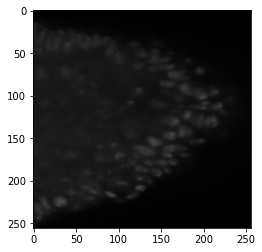

In [74]:
plt.imshow(test_img[0])